### Porting to Colab

In [1]:
!pip install torchviz

In [2]:
try:
    from google.colab import drive
    import sys
    import os
    root_directory = '/content/gdrive/'
    this_notebook_google_path = root_directory + 'Othercomputers/My Laptop/projects/RUNI/DL_TA/cs236781-tutorials/t01 - linear models'
    drive.mount(root_directory)
    # enable import python files from this notebook's path
    sys.path.append(this_notebook_google_path)
    # enable reading images and data files from this notebook's path
    os.chdir(this_notebook_google_path)
except:
    # no Google Colab --> fall back to local machine
    pass


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


$$\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
\newcommand{\E}[2][]{\mathbb{E}_{#1}\left[#2\right]}
\newcommand{\given}[]{~\middle\vert~}$$

$$\newcommand{\E}[2][]{\mathbb{E}_{#1}\left[#2\right]}$$

$$\renewcommand{\mat}[1]{\boldsymbol {#1}}
\renewcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\renewcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\renewcommand{\vec}[1]{\boldsymbol {#1}}
\renewcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\renewcommand{\rvar}[1]{\mathrm {#1}}
\renewcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\renewcommand{\diag}{\mathop{\mathrm {diag}}}
\renewcommand{\set}[1]{\mathbb {#1}}
\renewcommand{\norm}[1]{\left\lVert#1\right\rVert}
\renewcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\renewcommand{\bb}[1]{\boldsymbol{#1}}
\renewcommand{\E}[2][]{\mathbb{E}_{#1}\left[#2\right]}
\renewcommand{\given}[]{~\middle\vert~}$$



# CS236781: Deep Learning
# Tutorial 1: Supervised Learning

## Introduction

In this tutorial, we will cover:

* Basics of supervised learning
    - Definitions
    - Basics of optimization
    - Types of errors
* Classic ML example: Binary logistic regression from scratch using numpy (**self study**)
* Multiclass logistic regression from scratch with PyTorch and autograd
    - Optimization
    - Writing training loops

In [3]:
# Setup
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [4]:
plt.rcParams['font.size'] = 20

In [5]:
def show_single_image(file_name: str) -> None:
    # Load the images
    image1 = mpimg.imread(file_name)

    # Create subplots with 1 row and 1 columns
    fig, axes = plt.subplots(1, 1, figsize=(10, 5))

    # Plot the first image on the left subplot
    axes.imshow(image1)
    axes.axis('off')  # Turn off axis
    axes.set_title(file_name)  # Set title

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()


## Theory Reminders

### The supervised learning framework

We have a labeled dataset of $N$ labelled samples: $\mathcal{S} = \{ (\vec{x}^i,y^i) \}_{i=1}^N$, where
- $\vec{x}^i = \left(x^i_1, \dots, x^i_D\right) \in \mathcal{X}$  is a **sample** or **feature vector**.
- $y^i \in \mathcal{Y}$ is the **label**.
- For classification with $C$ classes, $\mathcal{Y} = \{0,\dots,C-1\}$, so each $y^i$ is a **class label**.
- Probabilistic perspective: assume each labeled sample $(\vec{x}^i,y^i)\sim\mathcal{D}$,
  i.e. each labeled sample is drawn from a joint distribution $\mathcal{D}$ over $\mathcal{X}\times\mathcal{Y}$.

Our **model** is a parametrized set of functions $\mathcal{H}\subseteq \mathcal{Y}^{\mathcal{X}}$.

($\mathcal{Y}^{\mathcal{X}}$ is the set of all functions from $\mathcal{X}$ to $\mathcal{Y}$).

From a probabilistic perspective, a model is a posterior: $P_{Y|\vec{X}}(y, \vec{x})$.

For example, the following hypothesis class
$$
\mathcal{H} =
\left\{ h: \mathcal{X}\rightarrow\mathcal{Y}
~\vert~
h(\vec{x}) = \varphi(\vec{w}^\top\vec{x}+b); \vec{w}\in\set{R}^D,~b\in\set{R}\right\}
$$
where $\varphi(\cdot)$ is some nonlinear function, is known as the **perceptron** model, and is also called a **neuron** in the context of a neural network (due to it's biologically-inspired origin).


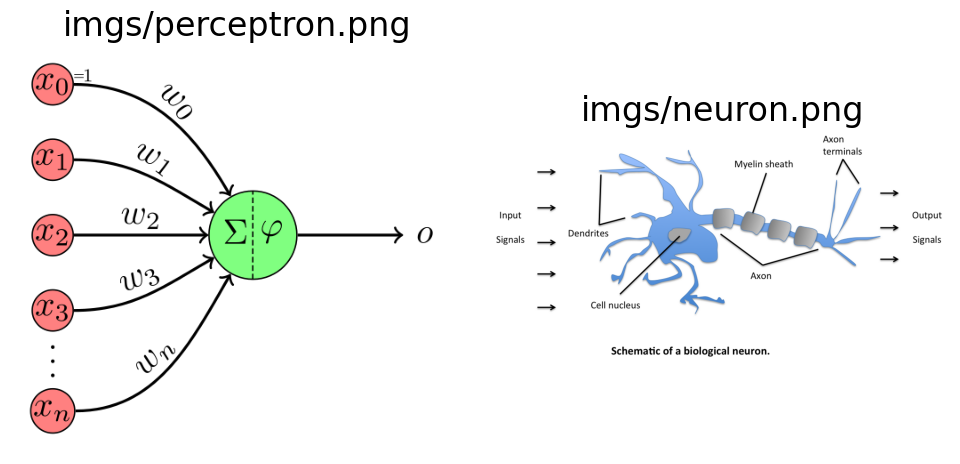

In [6]:
# Load the images
image1 = mpimg.imread('imgs/perceptron.png')
image2 = mpimg.imread('imgs/neuron.png')

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left subplot
axes[0].imshow(image1)
axes[0].axis('off')  # Turn off axis
axes[0].set_title('imgs/perceptron.png')  # Set title

# Plot the second image on the right subplot
axes[1].imshow(image2)
axes[1].axis('off')  # Turn off axis
axes[1].set_title('imgs/neuron.png')  # Set title

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


A **pointwise loss function** is some $\ell:\mathcal{Y}\times\mathcal{Y}\to\set{R}_{\geq 0}$, e.g.
- $\ell(y,\hat{y})=(y-\hat{y})^2$
- $\ell(y,\hat{y})= -y\log(\hat{y})-(1-y)\log(1-\hat{y})$

The task: Given the training set $\mathcal{S} = \{ (\vec{x}^i,y^i) \}_{i=1}^N \sim \mathcal{D}$, find
a predictor (hypothesis) $h: \mathcal{X}\to\mathcal{Y}$ which minimizes **population loss**:

$$
L_{\mathcal{D}}(h) = \E[(\vec{x},y)\sim\mathcal{D}]{\ell(y, h(\vec{x}))}.
$$

This is also known as the **out-of-sample** loss. It is a deterministic quantity?

Yes, it's the true expectation of an RV.

Can we solve this problem?

Joint-distribution $\mathcal{D}$ is unknown!

Instead, we define an **empirical (in-sample) loss** $L_{\mathcal{S}}(h)$ as the measure of how well a function $h\in\mathcal{H}$ fits the data $\mathcal{S}$, for example
$$
L_{\mathcal{S}}(h) = \frac{1}{N} \sum_{i=1}^{N} \ell(h(\vec{x}^i), y^i) + R(h)
$$
where

- $\ell(y,\hat{y})$ is some pointwise loss (depends on the data).
- $R(h)$ is a regularization term (depends only on the model).

Is this is a deterministic quantity?

### Optimization

The model is **trained** by updating its parameters to improve its performance on some data.

We wish to find a parametrization $\vec{w}^\ast$ of our model $h^{\ast}_{\mathcal{S}}(\vec{x};\vec{w}^\ast)\in\mathcal{H}$ such that
$$
h^{\ast}_{\mathcal{S}} = \arg\min_{h\in\mathcal{H}} L_{\mathcal{S}}(h)
$$

Usual approach: descent-based optimization (will be covered in next lecture)
$$
\vec{w}_{k+1} \leftarrow \vec{w}_{k} - \eta_k \vec{d}_{k}
$$

Where $\vec{d}_k$ is a **descent direction** and $\eta_k$ is the step size at step $k$.

Most common choice for $\vec{d}_k$?

Gradient descent: $\vec{d}_k = \nabla_{\vec{w}_{k}} L(\vec{w}_{k})$

Will we find the optimal solution, $\vec{w}^\ast$, though?

Generally the loss is non-convex and we have no guarantee of converging to the global optimum!
$\Rightarrow$ **Optimization Error**

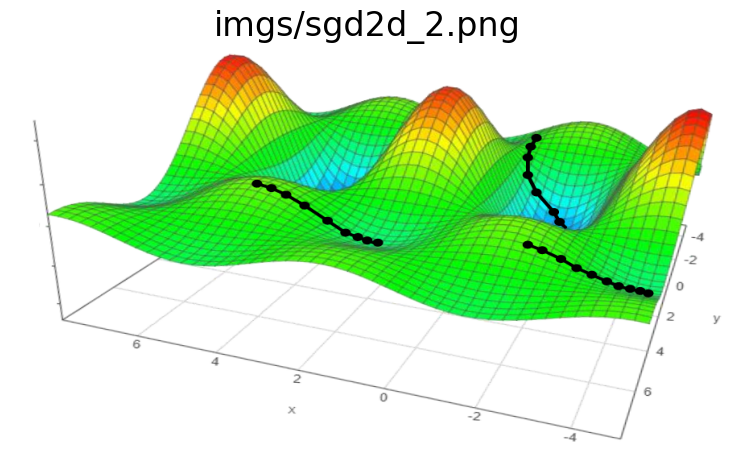

In [7]:
show_single_image('imgs/sgd2d_2.png')

Gradient descent (GD) has the advantage of being extremely simple to apply, and requires only first-order derivatives.

However it provides no guarantees for convergence on non-convex objectives.

Later in the course we'll learn about variants of GD which perform well in practice even on the non-convex objectives we'll face in deep learning.

Important below!

### Generalization and Expressiveness

We've talked about optimization error.

What are **other** sources of errors in our learning approach (besides optimization)?

We train to minimize our empirical loss $L_\mathcal{S}$ instead of the population loss $L_\mathcal{D}$ $\Rightarrow$ **Generalization Error**

We only consider a limited set of possible functions, $\mathcal{H}$ $\Rightarrow$ **Approximation Error**

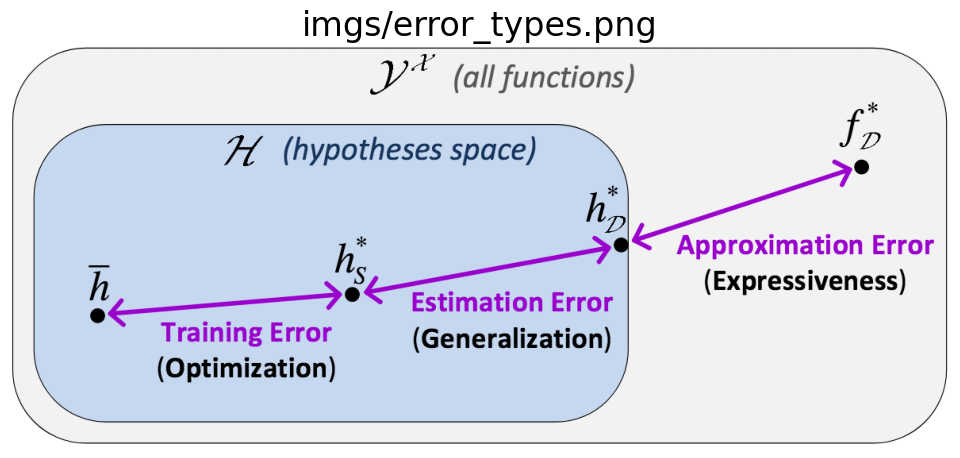

In [8]:
show_single_image('imgs/error_types.png')

How do we mitigate these errors in the practice of machine learning?

- Optimization error: Mini batches; GD variants like stochastic gradient, Momentum, Adam, LR scheduling, etc (we'll see later in the course).

- Generalization error: Get more data; get data which better represents $\mathcal{D}$; train-test splits; cross validation; early stopping; regularization.

- Approximation error: Use a powerful hypothesis class (e.g. DNN); more parameters; "inductive bias" - tailoring the model to the domain (e.g. CNN for images).

### Binary Logistic Regression

Actually a **classification** model. We're trying to classify data into 2 classes.

- Domain: $\vec{x}^i \in \set{R}^D$
- Target: $y^i \in \{0,1\}$
- Model: $\hat{y} = h(\vec{x}) = \sigma(\vec{w}^\top\vec{x}+b)$, where $\sigma(\vec{z})$ is the **logistic function**:
    $$\sigma(\vec{z}) = \frac{1}{1+e^{-\vec{z}}}.$$
    This function maps the real line onto $[0,1]$.
- Probabilistic interpretation: $\hat{y}=P(\mathrm{Y}=1|\boldsymbol{\mathrm{X}}=\vec{x})$.
  This is a posterior probability function for our target variable $\mathrm{Y}$.

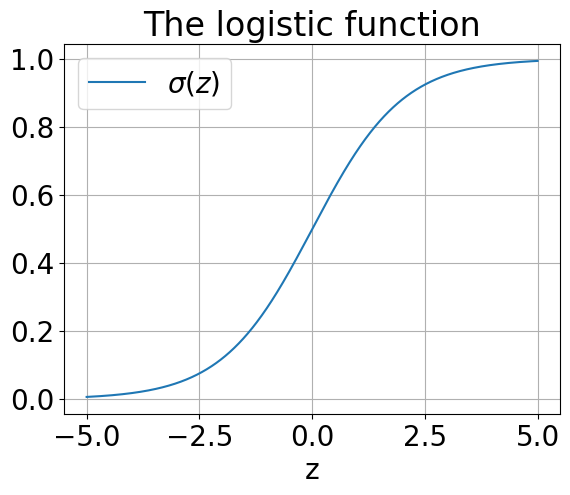

In [9]:
def logistic(z):
    return 1 / (1 + np.exp(-z))

x = np.arange(-5, 5, .01)
y_hat = logistic(x)

plt.plot(x, y_hat, label='$\sigma(z)$')
plt.grid(True); plt.xlabel('z'); plt.legend(); plt.title('The logistic function');

To optimize, we minimize the **negative log-likelihood** (equivalent to maximizing likelihood, i.e. MLE) of the parameters $\vec{w}$:

$$
\bb{w}^\ast = \mathrm{arg}\max_{ \bb{w}} \prod_{i=1}^n P(y_i | \bb{x}_i;\vec{w}) = \mathrm{arg}\min_{ \bb{w}} \sum_{i=1}^n -\log P(y_i | \bb{x}_i; \vec{w})
$$

Based on this we define our loss $L(\bb{w})$ (what we minimize) as,

$$
\begin{align}
L(\bb{w}) &\triangleq \sum_{i=1}^n -\log P(y_i | \bb{x}_i; \vec{w})\\
&= \sum_{i=1}^n -y_i \log P(y_i=1 | \bb{x}_i; \vec{w}) - (1-y_i) \log P(y_i=0 | \bb{x}_i; \vec{w}) \\
&= \sum_{i=1}^n -y_i \log \hat{y}_i - (1-y_i) \log(1-\hat{y}_i)
\end{align}
$$

The resulting pointwise loss is also known as **cross-entropy**:
$$
\begin{align}
\ell(y, \hat{y}) &=  - y \log(\hat{y}) - (1-y) \log(1-\hat{y}) \\
\end{align}
$$

(The "cross" here is between the distribution of the samples $y^i$ and the distribution of the predictions $\hat{y}^i$).

Optimization scheme: No closed form solution, but loss is **convex** so gradient-based approach leads to global optimum.

$$
\begin{align}
\ell(y, \hat{y}) &=  - y \log(\hat{y}) - (1-y) \log(1-\hat{y}) \\
\end{align}
$$

Let's plot this loss function:

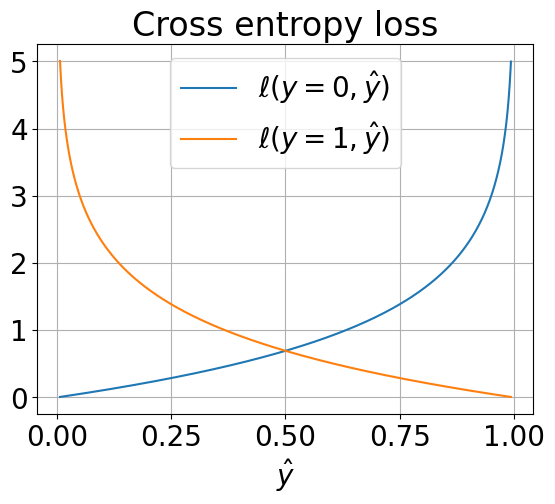

In [10]:
loss_y0 = -np.log(1-y_hat)
loss_y1 = -np.log(y_hat)
plt.plot(y_hat, loss_y0, label='$\ell(y=0,\hat{y})$')
plt.plot(y_hat, loss_y1, label='$\ell(y=1,\hat{y})$')
plt.grid(True); plt.xlabel('$\hat{y}$'); plt.legend(); plt.title('Cross entropy loss');

To apply gradient descent, we need to know the gradient of the loss w.r.t. the parameters $\vec{w}$.

Exercise: Prove that for the cross entropy loss with binary logistic regression, it holds that:
$$
\pderiv{\ell(y,\hat{y})}{\vec{w}}= (\hat{y}-y)\vec{x}.
$$

Proof:

First, we apply the chain-rule
$$
\pderiv{\ell(y,\hat{y})}{\vec{w}}=\pderiv{\ell}{\hat{y}}\cdot\pderiv{\hat{y}}{z}\cdot\pderiv{z}{\vec{w}},
$$
where $z=\vectr{w}\vec{x}$.

Now, just by definition,
$$
\begin{align}
\pderiv{\ell}{\hat{y}}&=-\frac{y}{\hat{y}}+\frac{1-y}{1-\hat{y}}=\frac{\hat{y}-y}{\hat{y}(1-\hat{y})}\\
\pderiv{\hat{y}}{z}&=\frac{e^{-z}}{(1+e^{-z})^2}=
\frac{e^{-z}}{1+e^{-z}}\cdot\frac{1}{1+e^{-z}}=(1-\sigma(z))\sigma(z)=(1-\hat{y})\hat{y}\\
\pderiv{z}{\vec{w}}&=\vec{x}
\end{align}
$$

## Part 1: Binary Logistic Regression

As a warm up exercise, let's see a quick example of implementing this algorithm and training it from scratch using just `numpy` (and a toy dataset from `sklearn`).

This is a classic and very simple example of implementing and training a machine learning algorithm.

## Dataset

The `scikit-learn` library comes with a few [toy datasets](http://scikit-learn.org/stable/datasets/index.html#toy-datasets) that are fun to quickly train small models on.

As an example we'll load the Wisconsin-breast cancer database:
- 569 samples of cancer patients
- 30 features: various properties of tumor cells extracted from images
- 2 classes: Tumor is either Benign or Malignant

We'll apply the basic machine learning approach we saw above: binary logistic regression.

In [11]:
import sklearn.datasets

ds_cancer = sklearn.datasets.load_breast_cancer()
feature_names = ds_cancer.feature_names
target_names = ds_cancer.target_names
n_features = len(feature_names)

print(f'{n_features=}')
print(f'feature names: {feature_names}')
print(f'target  names: {target_names}')

n_features=30
feature names: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
target  names: ['malignant' 'benign']


In [12]:
X, y = ds_cancer.data, ds_cancer.target
n_samples = len(y)

print(f'X: {X.shape}')
print(f'y: {y.shape}')

X: (569, 30)
y: (569,)


In [13]:
# Load into a pandas dataframe and show some samples
y_names = np.full_like(y, target_names[0].upper(), dtype=target_names.dtype)
y_names[y==1] = target_names[1].upper()

df_cancer = pd.DataFrame(data=X, columns=ds_cancer.feature_names)
df_cancer = df_cancer.assign(CLASS=y_names)
df_cancer.iloc[100:110, 0::3]

,mean radius,mean area,mean concavity,mean fractal dimension,perimeter error,compactness error,symmetry error,worst texture,worst smoothness,worst concave points,CLASS
100,13.610,582.7,0.08625,0.05871,2.8610,0.014880,0.01465,35.27,0.1265,0.11840,MALIGNANT
101,6.981,143.5,0.00000,0.07818,1.5530,0.010840,0.02659,19.54,0.1584,0.00000,BENIGN
102,12.180,458.7,0.02383,0.05677,1.1830,0.006098,0.01447,32.84,0.1123,0.07431,BENIGN
103,9.876,298.3,0.06154,0.06322,1.5280,0.021960,0.01609,26.83,0.1559,0.09749,BENIGN
104,10.490,336.1,0.02995,0.06481,2.3020,0.022190,0.02710,23.31,0.1219,0.03203,BENIGN
105,13.110,530.2,0.20710,0.07692,2.4100,0.029120,0.01547,22.40,0.1862,0.19860,MALIGNANT
106,11.640,412.5,0.07070,0.06520,2.1550,0.023100,0.01565,29.26,0.1688,0.12180,BENIGN
107,12.360,466.7,0.02643,0.06066,0.8484,0.010470,0.01251,27.49,0.1184,0.08442,BENIGN
108,22.270,1509.0,0.42640,0.07039,10.0500,0.086680,0.03112,28.01,0.1701,0.29100,MALIGNANT
109,11.340,396.5,0.05133,0.06529,1.5970,0.015570,0.01568,29.15,0.1699,0.08278,BENIGN


In [14]:
# Split into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f'train: X={X_train.shape} y={y_train.shape}')
print(f'test : X={X_test.shape} y={y_test.shape}')

train: X=(398, 30) y=(398,)
test : X=(171, 30) y=(171,)


In [15]:
# Standardize the features

# Note: each feature is standardized individually:
mu_X = np.mean(X_train, axis=0) # (N, D) -> (D,)
sigma_X = np.std(X_train, axis=0)

# Note: Broadcasting (N, D) with (D,) -> (N, D)
X_train_sc = (X_train - mu_X) / sigma_X

# Note: Test set must be transformed identically to training set
X_test_sc = (X_test - mu_X) / sigma_X

print(f'{mu_X.shape=}, {sigma_X.shape=}')

mu_X.shape=(30,), sigma_X.shape=(30,)


## Model Implementation

We'll implement based on the above definitions.

The model will be implemented as a class with an API that conforms to the `sklearn` models, specifically see
`sklearn`'s [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) class.


In [16]:
class BinaryLogisticRegression(object):
    def __init__(self, n_iter=100, learn_rate=0.1):
        self.n_iter = n_iter
        self.learn_rate = learn_rate
        self._w = None

    def _add_bias(self, X: np.ndarray):
        # Add a bias term column
        ones_col = np.ones((X.shape[0], 1))
        return np.hstack([ones_col, X])

    def predict_proba(self, X: np.ndarray, add_bias=True):
        X = self._add_bias(X) if add_bias else X

        # Apply logistic model
        z = np.dot(X, self.weights) # (N, D) * (D,)
        return logistic(z) # shape (N,)

    def predict(self, X: np.ndarray):
        proba = self.predict_proba(X)

        # Apply naive threshold of .5
        return np.array(proba > .5, dtype=np.int32)

    def fit(self, X: np.ndarray, y: np.ndarray):
        n, d = X.shape # X is (N, D), y is (N,)

        # Initialize weights
        self._w = np.random.randn(d + 1) * 0.1

        Xb = self._add_bias(X)

        # Training loop
        self._losses = []
        for i in range(self.n_iter):
            # Predicted probabilities
            y_hat = self.predict_proba(Xb, add_bias=False)

            # Pointwise loss
            loss = -y.dot(np.log(y_hat)) - ((1 - y).dot(np.log(1 - y_hat)))

            # See Exercise for gradient derivation
            loss_grad = 1/n * Xb.T.dot(y_hat - y)  # dl/dw: (D+1, N) * (N,)

            # Optimization step
            self._w += -self.learn_rate * loss_grad
            self._losses.append(loss)

        return self

    @property
    def weights(self):
        if self._w is None:
            raise ValueError("Model is not fitted")
        return self._w

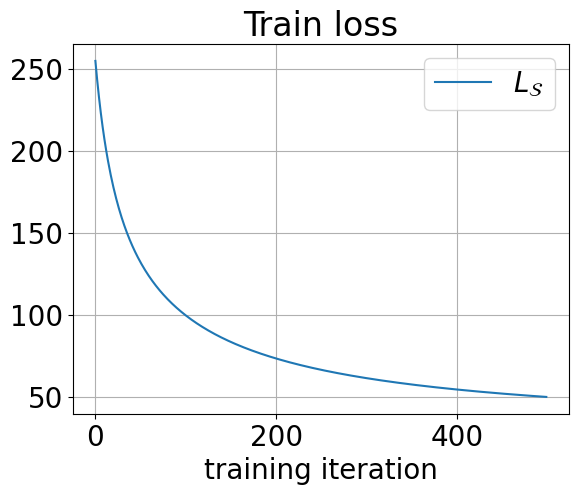

In [17]:
# Fit the model to the training data
lr_model = BinaryLogisticRegression(n_iter=500, learn_rate=0.01)
lr_model.fit(X_train_sc, y_train)

plt.plot(lr_model._losses, label='$L_{\mathcal{S}}$');
plt.xlabel('training iteration'); plt.legend(); plt.grid(True); plt.title('Train loss');

In [18]:
y_train_pred = lr_model.predict(X_train_sc)
train_acc = np.mean(y_train_pred == y_train)
print(f'train set accuracy: {train_acc*100:.2f}%')

y_test_pred = lr_model.predict(X_test_sc)
test_acc = np.mean(y_test_pred == y_test)
print(f'test set accuracy: {test_acc*100:.2f}%')

train set accuracy: 97.49%
test set accuracy: 97.08%


## Part 2: Multiclass Logistic Regression

What if we have $C$ classes? Can we still use logistic regression?

A naïve approach is to train $C$ binary logistic regression classifiers, for example in a One vs. Rest scheme,
and then predict based on the classifier returning the greatest probability.

One major drawback of this approach is that it doesn't model the probability distribution over the possible classes, $P_{\vec{Y}|\vec{X}}$.

For example, a sample might be classified as class A with probability $0.8$ and class $B$ with $0.7$ since nothing constrains the different classifiers.

Also, without *calibrating* each model, their raw scores cannont reliably be compared even though they're in the same range.

### The softmax function

**Softmax** is a function which can generate a probability distribution for our $C$ classes given raw prediction scores. It's defined as follows:

$$
\mathrm{softmax}(\vec{z}) = \frac{e^{\vec{z}}}{\sum_{j=1}^{C} e^{z_j}}
$$

note that this is a vector valued, multivariate function. The exponent in the enumerator operates elementwise.

The result of softmax is a vector with elements in $[0,1]$ that all sum to $1$.

### The multiclass model

Our model can now be defined as

$$\hat{\vec{y}} = h(\vec{x}) = \mathrm{softmax}(\mattr{W}\vec{x}+\vec{b})$$

where,
- $\hat{\vec{y}}$ is a $C\times 1$ vector of class probabilities.
- ${\vec{x}}$ is a $D\times 1$ sample.
- $\mat{W}$ is a $D\times C$ matrix representing the per-class weights.
- $\vec{b}$ is a per-class bias vector of length $C$.

Probabilistic interpretation: $\hat{y}_j = P(\rvar{Y}=j|\rvec{X}=\vec{x})$.

While not very powerful on it's own, this type of model is commonly found at the end of deep neural networks performing classification tasks.

To train such a model we need our labels to also be singleton probability distributions instead of simply the number of the correct class.

We'll transform our labels to a 1-hot encoded vector corresponding to a delta distribution.
For example, if $y^i=j$ then we'll create
$$
\vec{y}^i = [0,\dots,0,\underbrace{1}_{j\mathrm{th\ component}},0,\dots,0]^\top
$$

### Cross-Entropy loss

After defining the 1-hot label vectors, the multiclass extension of the binary cross-entropy is straightforward:

$$
\ell(\vec{y}, \hat{\vec{y}}) = - \vectr{y} \log(\hat{\vec{y}})
$$

Note that only the probability assigned to the correct class affects the loss.

Minimizing this cross entropy can be interpreted as trying to move the probability distribution of model predictions towards the singleton distribution of the appropriate class.

### Dataset

This time we'll tackle an image classification task, the MNIST database of handwritten digits.

Today this is also considered a toy dataset, even though it was used in the past to benchmark classification algorithms.

In [19]:
import os
import torch
import torch.autograd
import torch.utils.data
import torchvision
import torchvision.transforms
import plot_utils

from torch import Tensor

In [20]:
# Define the transforms that should be applied to each image in the dataset before returning it
tf_ds = torchvision.transforms.ToTensor()

batch_size = 64
data_root = os.path.expanduser("~/.pytorch-datasets")

# Training and test datasets
ds_train, ds_test = [
    torchvision.datasets.MNIST(root=data_root, download=True, train=train, transform=tf_ds)
    for train in [True, False]
]

# Data loaders
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=len(ds_test))

x0, y0 = ds_train[0]
n_features = torch.numel(x0)
n_classes = 10

x0: torch.Size([1, 28, 28]), y0: 5


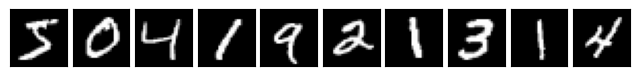

In [21]:
# Show first few samples
print(f'x0: {x0.shape}, y0: {y0}')
plot_utils.dataset_first_n(ds_train, 10, cmap='gray');

Note that when training, we're actually working with **batches** of samples (we'll learn about SGD in the sebsequent lectures/tutorials):

In [22]:
x0, y0 = next(iter(dl_train))
x0.shape

torch.Size([64, 1, 28, 28])

### Model Implementation

This time we'll use `pytorch` tensors and its [`autograd`](https://pytorch.org/docs/stable/autograd.html) functionality to implement our model.

This means we wont have to implement any gradient calculations!

First, let's implement $\mathrm{softmax}(\cdot)$. We need a small numerical trick to prevent large numbers from exploding the exponentiation. You can verify that this doesn't influence the result.

In [23]:
def softmax(z: Tensor) -> Tensor:
    """
    softmax(z)= e^(z) / sum(e^z)
    :param z: A batch of C class scores per N samples, shape (N, C).
    :returns: softmax per sample, of shape (N, C).
    """

    # normalization trick to prevent numerical instability:
    # shift so that the highest class score (per sample) is 0
    zmax, _ = torch.max(z, dim=1, keepdim=True)
    z = z - zmax # note broadcasting: (N,C) - (N,1)

    exp_z = torch.exp(z) # (N, C)
    sum_exp = torch.sum(exp_z, dim=1, keepdim=True) # (N, 1)
    return exp_z / sum_exp # probabilities, (N,C)

Let's test our softmax and calculate its derivative with `autograd`.

In [24]:
z = torch.randn(size=(4,3), requires_grad=True)
y = softmax(z)
y

tensor([[0.4317, 0.3728, 0.1955],
        [0.5281, 0.1944, 0.2776],
        [0.3973, 0.3277, 0.2750],
        [0.2966, 0.1778, 0.5257]], grad_fn=<DivBackward0>)

In [25]:
y = softmax(z)
L = torch.sum(y) # scalar function of z

# Calculate gradient: dL/dz
torch.autograd.grad(L, z)

(tensor([[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]),)

In [26]:
# Calculate gradient: dL/dy
torch.autograd.grad(L, y)

(tensor([[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]),)

Instead of calling `autograd.grad()` directly with specific input tensors, `pytorch` provides us with a way to calculate the derivative of a tensor w.r.t. all the tensors which are **leaves** in it's computation graph (only $\vec{z}$ in this case).

This can be done by calling `.backward()` on a scalar tensor.
As a result, the `.grad` property of leaf tensors will be populated with the gradient:

In [27]:
# Example with two leaves in the computaion graph
z1 = torch.randn(size=(4,3), requires_grad=True)
z2 = torch.randn(size=(1,3), requires_grad=True)
z = z1 - z2

y = softmax(z)
L = torch.sum(y) # scalar function of z
L.backward()     # Calculate derivative w.r.t. all leaves

z1.grad, z2.grad # The leaves z1, z2 will have their .grad populated

(tensor([[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]),
 tensor([[0., 0., 0.]]))

Here's the resulting computation graph:

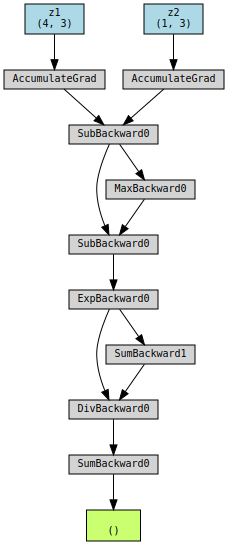

In [28]:
import torchviz
torchviz.make_dot(L, params=dict(z1=z1, z2=z2))

The next ingredient of the solution is the cross-entropy loss function.

Recall that we need to encode our ground-truth labels as one-hot vectors to apply the multiclass cross-entropy.

In [29]:
def cross_entropy_loss(y: Tensor, y_hat: Tensor, eps=1e-6):
    """
    :param y:  Onehot-encoded ground-truth labels, shape (N, C)
    :param y_hat: A batch of probabilities, shape (N,C)
    :returns: Cross entropy between y and y_hat.
    """
    return torch.sum( - y * torch.log(y_hat + eps) )

In [30]:
def onehot(y: Tensor, n_classes: int) -> Tensor:
    """
    Encodes y of shape (N,) containing class labels in the range [0,C-1] as one-hot of shape (N,C).
    """
    y = y.reshape(-1, 1) # Reshape y to (N,1)
    zeros = torch.zeros(size=(len(y), n_classes), dtype=torch.float32) # (N,C)
    ones = torch.ones_like(y, dtype=torch.float32)

    # scatter: put items from 'src' into 'dest' at indices correspondnig to 'index' along 'dim'
    y_onehot = torch.scatter(zeros, dim=1, index=y, src=ones)

    return y_onehot # result has shape (N, C)

In [31]:
onehot(torch.tensor([1, 3, 5, 0]), n_classes=10)

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

Our model itself will just hold the parameters $\mat{W}$ and $\vec{b}$ and apply them to an input batch $\mat{X}$.

In [32]:
class MCLogisticRegression(object):
    def __init__(self, n_features: int, n_classes: int):
        # Define our parameter tensors: notice that now W and b are separate
        # Specify we want to track their gradients with autograd
        self.W = torch.randn(n_features, n_classes, requires_grad=True)
        self.b = torch.randn(n_classes, requires_grad=True)
        self.params = [self.W, self.b]

    def __call__(self, *args):
        return self.forward(*args)

    def forward(self, X: Tensor):
        """
        :param X: A batch of samples, (N, D)
        :return: A batch of class probabilities, (N, C)
        """
        # X is (N, D), W is (D, C), b is (C,)
        z = torch.mm(X, self.W) + self.b
        y_hat = softmax(z)
        return y_hat # (N, C)

Let's try out the model and loss on the first batch.

Note that we naïvely treat each pixel as a separate feature. We'll learn how to properly work with images in a future tutorial.

In [33]:
model = MCLogisticRegression(n_features, n_classes)

# Flatten images and convert labels to onehot
x0_flat = x0.reshape(-1, n_features)
y0_onehot =  onehot(y0, n_classes)

print(f'x0_flat: {x0_flat.shape}')
print(f'y0_onehot: {y0_onehot.shape}\n')

x0_flat: torch.Size([64, 784])
y0_onehot: torch.Size([64, 10])



In [34]:
# Forward pass and compute loss
y0_hat = model(x0_flat)
loss = cross_entropy_loss(y0_onehot, y0_hat)
print('loss = ', loss)

# Backward pass to populate .grad on leaf nodes
loss.backward()

loss =  tensor(547.3476, grad_fn=<SumBackward0>)


Since we specified `require_grad=True` for our model parameters, every operation performed on these tensors is recorded, and a **computation graph** can be built, which included the model and loss calculation.
Notice that the **leaves** in this graph are our parameters $\mat{W}$ and $\vec{b}$.

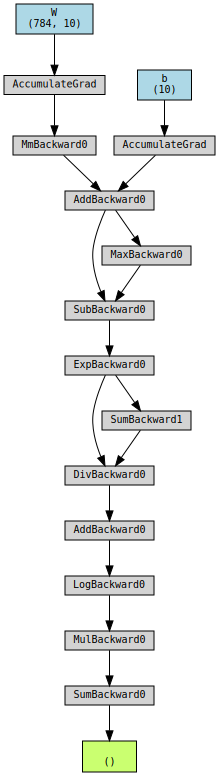

In [35]:
import torchviz
torchviz.make_dot(loss, params=dict(W=model.W, b=model.b))

This graph is what allows efficient implementation of the **back-propagation** algorithm which you'll learn about in the next lecture.

By calling `.backward()` from the final loss tensor, pytorch automatically populated the `.grad` property of all leaves in this graph, without us having to explicitly specify them (`W` and `b`).

### Training

The optimization will be as before, but now we'll take the gradients from the `grad` property of our parameter tensors.

Therefore, the optimizer only needs access to the parameter tensors from the model.
Later you'll see that `pytorch`'s `Optimizer` classes work in the same way.

In [36]:
from typing import Sequence

class SGDOptimizer:
    """
    A simple gradient descent optimizer.
    """
    def __init__(self, params: Sequence[Tensor], learn_rate: float):
        self._params = params
        self._learn_rate = learn_rate

    def step(self):
        """
        Updates parameters in-place based on their gradients.
        """
        with torch.autograd.no_grad(): # Don't track this operation
            for param in self._params:
                if param.grad is not None:
                    param -= self._learn_rate * param.grad

    def zero_grad(self):
        """
        Zeros the parameters' gradients if they exist.
        """
        for param in self._params:
            if param.grad is not None:
                param.grad.zero_()

Inference and prediction accuracy:

In [37]:
def evaluate_accuracy(dataloader, model, max_batches=None):
    n_correct = 0.
    n_total = 0.
    for i, (X, y) in enumerate(dataloader):
        X = X.reshape(-1, n_features) # flatten images into vectors

        # Forward pass
        with torch.autograd.no_grad():
            y_hat = model(X)

        predictions = torch.argmax(y_hat, dim=1)
        n_correct += torch.sum(predictions == y).type(torch.float32)
        n_total += X.shape[0]

        if max_batches and i+1 >= max_batches:
            break

    return (n_correct / n_total).item()

test_set_acc = evaluate_accuracy(dl_test, MCLogisticRegression(n_features, n_classes))
print(f'Test set accuracy pre-training: {test_set_acc*100:.2f}%')

Test set accuracy pre-training: 6.02%


#### The training loop

This is a crucial part of any ML pipeline where model parameters get updated iteratively.

One pass over the entire training data is called an **epoch**.
When using `pytorch`, your training loop will generally contain the following steps:

- Each epoch:
    - Split training data into batches
    - For each batch
        - Forward pass: Compute predictions and build computation graph
        - Calculate loss
        - Set existing gradients to zero
        - Backward pass: Use back-propagation algorithm to calculate the gradients
        - Optimization step: Use the gradients to update the parameters
    - Evaluate accuracy on validation set

In [38]:
# Define some training hyper-parameters
epochs = 10
max_batches = 50  # limit batches so training is fast (just as a demo)
learn_rate = .005
num_samples = len(ds_train)

# Instantiate the model we'll train
model = MCLogisticRegression(n_features, n_classes)

# Instantiate the optimizer with model's parameters
optimizer = SGDOptimizer(model.params, learn_rate=learn_rate)

In [39]:
# Epoch: traverse all samples
for e in range(epochs):
    cumulative_loss = 0

    # Loop over randdom batches of training data
    for i, (X, y) in enumerate(dl_train):

        X = X.reshape(-1, n_features)
        y_onehot = onehot(y, n_classes)

        # Forward pass: predictions and loss
        y_hat = model(X)
        loss = cross_entropy_loss(y_onehot, y_hat)

        # Clear previous gradients
        optimizer.zero_grad()

        # Backward pass: calculate gradients
        loss.backward()

        # Update model using the calculated gradients
        optimizer.step()

        cumulative_loss += loss.item()
        if i+1 > max_batches:
            break

    # Evaluation
    test_accuracy = evaluate_accuracy(dl_test, model, max_batches)
    train_accuracy = evaluate_accuracy(dl_train, model, max_batches)

    avg_loss = cumulative_loss/num_samples
    print(f"Epoch {e}. Avg Loss: {avg_loss:.3f}, Train Acc: {train_accuracy*100:.2f}, Test Acc: {test_accuracy*100:.2f}")

Epoch 0. Avg Loss: 0.317, Train Acc: 49.41, Test Acc: 48.79
Epoch 1. Avg Loss: 0.139, Train Acc: 65.28, Test Acc: 65.32
Epoch 2. Avg Loss: 0.094, Train Acc: 71.84, Test Acc: 71.88
Epoch 3. Avg Loss: 0.075, Train Acc: 73.81, Test Acc: 75.58
Epoch 4. Avg Loss: 0.067, Train Acc: 78.12, Test Acc: 77.95
Epoch 5. Avg Loss: 0.054, Train Acc: 79.03, Test Acc: 79.78
Epoch 6. Avg Loss: 0.054, Train Acc: 81.50, Test Acc: 81.14
Epoch 7. Avg Loss: 0.057, Train Acc: 81.72, Test Acc: 82.08
Epoch 8. Avg Loss: 0.050, Train Acc: 83.66, Test Acc: 83.10
Epoch 9. Avg Loss: 0.045, Train Acc: 81.81, Test Acc: 83.20


#### Final notes

- This is a very naive implementation, for example because
    - We didn't treat the images properly.
    - We didn't include any regularization.

- PyTorch provides many functions and classes that we could have used, for example:
  - Fully connected layer with model parameters
  - Softmax
  - SGD and many other optimizers
  - Cross entropy loss
  
  however the purpose here was to show an (almost) from-scratch implementation using only tensors,
  in order to see whats "under the hood" (more or less) of the PyTorch functions.

### Thanks!

**Credits**

This tutorial was written by [Aviv A. Rosenberg](https://avivr.net).<br>
To re-use, please provide attribution and link to the original.

Some images in this tutorial were taken and/or adapted from the following sources:

- MartinThoma [CC0], via Wikimedia Commons https://commons.wikimedia.org/wiki/File:Perceptron-unit.svg
- Dr. Nadav Cohen, http://www.cohennadav.com/files/icermw19_slides.pdf
- Fundamentals of Deep Learning, Nikhil Buduma, Oreilly 2017